In [55]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_lg")

In [56]:
df = pd.read_json("news_dataset.json")
df.head()

,text,category
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS
3,This Richard Sherman Interception Literally Sh...,SPORTS
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS


In [57]:
df.value_counts(df.category)

category
BUSINESS    2500
CRIME       2500
SPORTS      2500
dtype: int64

In [58]:
df.shape

(7500, 2)

In [59]:
df['label_num'] = df.category.map({'BUSINESS': 0, 'CRIME': 1, 'SPORTS': 2})
df.head()

,text,category,label_num
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,1
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,1
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,2
3,This Richard Sherman Interception Literally Sh...,SPORTS,2
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,0


In [61]:
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return ' '.join(filtered_tokens)

In [62]:
df['preprocessed_text'] = df.text.apply(preprocess)
df.head()

,text,category,label_num,preprocessed_text
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,1,Larry Nassar blame victim say victimize newly ...
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,1,woman beat cancer die fall horse
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,2,Vegas taxpayer spend Record $ 750 million New ...
3,This Richard Sherman Interception Literally Sh...,SPORTS,2,Richard Sherman Interception literally shake W...
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,0,7 thing totally kill Weed Legalization Buzz


In [63]:
df['vector'] = df.text.apply(lambda text: nlp(text).vector)
df.vector.head()

0    [-0.62528795, 0.30613044, -1.1252857, -1.52891...
1    [0.07858125, -1.8231387, 0.43582, -0.15502499,...
2    [-2.1691844, 1.8227255, -2.8935153, 0.37569532...
3    [-1.1437662, -1.0418652, 0.021148713, -0.85042...
4    [0.12745197, 0.47146398, -1.4749851, -0.184787...
Name: vector, dtype: object

In [64]:
len(df.preprocessed_text[0].split(' '))

16

In [65]:
len(df.vector[0])

300

In [66]:
df.head()

,text,category,label_num,preprocessed_text,vector
0,"Larry Nassar Blames His Victims, Says He 'Was ...",CRIME,1,Larry Nassar blame victim say victimize newly ...,"[-0.62528795, 0.30613044, -1.1252857, -1.52891..."
1,"Woman Beats Cancer, Dies Falling From Horse",CRIME,1,woman beat cancer die fall horse,"[0.07858125, -1.8231387, 0.43582, -0.15502499,..."
2,Vegas Taxpayers Could Spend A Record $750 Mill...,SPORTS,2,Vegas taxpayer spend Record $ 750 million New ...,"[-2.1691844, 1.8227255, -2.8935153, 0.37569532..."
3,This Richard Sherman Interception Literally Sh...,SPORTS,2,Richard Sherman Interception literally shake W...,"[-1.1437662, -1.0418652, 0.021148713, -0.85042..."
4,7 Things That Could Totally Kill Weed Legaliza...,BUSINESS,0,7 thing totally kill Weed Legalization Buzz,"[0.12745197, 0.47146398, -1.4749851, -0.184787..."


In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector,
    df.label_num,
    test_size=0.2,
    random_state=2022
    )

In [68]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [69]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=2022)
clf.fit(X_train_2d, y_train)

DecisionTreeClassifier(random_state=2022)

In [70]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       535
           1       0.63      0.65      0.64       486
           2       0.59      0.60      0.60       479

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.65      0.64      0.64      1500



In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

In [74]:
clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

In [75]:
y_pred = clf.predict(scaled_test_embed)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       535
           1       0.67      0.72      0.69       486
           2       0.70      0.66      0.68       479

    accuracy                           0.69      1500
   macro avg       0.69      0.69      0.69      1500
weighted avg       0.69      0.69      0.69      1500



In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = KNeighborsClassifier()

clf.fit(scaled_train_embed, y_train)

y_pred = clf.predict(scaled_test_embed)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       535
           1       0.73      0.81      0.77       486
           2       0.78      0.71      0.74       479

    accuracy                           0.77      1500
   macro avg       0.77      0.77      0.77      1500
weighted avg       0.78      0.77      0.77      1500



In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = RandomForestClassifier()

clf.fit(scaled_train_embed, y_train)

y_pred = clf.predict(scaled_test_embed)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       535
           1       0.80      0.81      0.80       486
           2       0.79      0.81      0.80       479

    accuracy                           0.81      1500
   macro avg       0.81      0.81      0.81      1500
weighted avg       0.81      0.81      0.81      1500



In [78]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = GradientBoostingClassifier()

clf.fit(scaled_train_embed, y_train)

y_pred = clf.predict(scaled_test_embed)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       535
           1       0.86      0.86      0.86       486
           2       0.86      0.87      0.86       479

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



Text(95.72222222222221, 0.5, 'Truth')

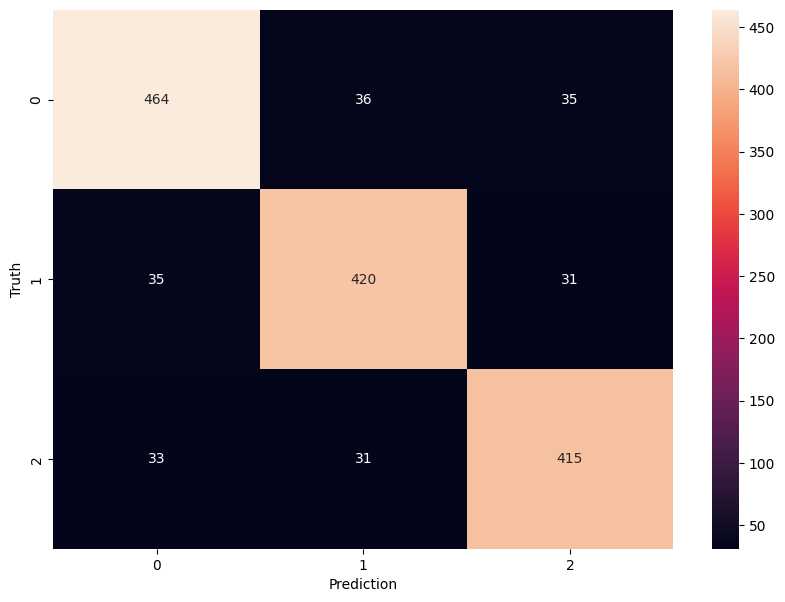

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')